# Goal
We want $$0 = \dot{\hat{\rho}} = \mathcal{L}\hat{\rho} = -i\left[\hat H, \hat \rho\right]+\sum_j \frac{\gamma_j}{2}\left[2\hat L_j\hat\rho\hat L_j^\dagger - \left\{\hat L_j^\dagger\hat L_j, \hat\rho\right\}\right]$$

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
import time

Pauli Matrices

In [2]:
sigma_x = np.array([[0, 1], [1, 0]], dtype = 'complex128')
sigma_y = np.array([[0, -1j], [1j, 0]], dtype = 'complex128')
sigma_z = np.array([[1, 0], [0, -1]], dtype = 'complex128')
identity = np.array([[1, 0], [0, 1]], dtype = 'complex128')

Some parameters

In [3]:
num_latt = 4
coup_stren = 2


$$ H = \frac{V}{4}\sum_{\langle j, l\rangle}\hat\sigma_j^z\hat\sigma_l^z+\frac{g}{2}\sum_j\hat\sigma_j^x$$
where $\hat\sigma_j^\alpha$ means the Pauli matrix acting on the $j$-th site.
$$ \hat L_j^{(z)} = \hat\sigma_j^- = \frac{1}{2}\left(\hat\sigma_j^x-i\hat\sigma_j^y\right)$$

In [4]:
# make tensor product of two matrices (copied over from povm code, 
# but I didn't reverse the order because later I shall use this function
# in a different order.)
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    # didn't reverse the order here
    return np.tensordot(matrix1, matrix2, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [5]:
# generate hamiltonion
def gen_H(num, V, g):
    hamiltonion = np.zeros((2**num, 2**num), dtype = 'complex128')
    for i in range(num):
        term1 = np.ones((1, 1), dtype = 'complex128')
        term2 = np.ones((1, 1), dtype = 'complex128')
        for j in range(num): 
            if j == i or j == i + 1 or (i == num - 1 and j == 0): # wallpaper(cyclic) bondary condition
                term1 = tensorproduct(term1, sigma_z) # order here not the same as in POVM
                #print(i, j)
                #print(term1)
            else:
                term1 = tensorproduct(term1, identity) # order here not the same as in POVM
            if j == i:
                term2 = tensorproduct(term2, sigma_x) # order here not the same as in POVM
            else:
                term2 = tensorproduct(term2, identity) # order here not the same as in POVM
        term1 = term1 * V / 4
        #print(term1)
        term2 = term2 * g / 2
        hamiltonion += term1 + term2
    return hamiltonion
                

In [6]:
# generate L_j
def gen_L_j(num, i):
    term = np.ones((1, 1), dtype = 'complex128')
    for j in range(num):
        if j == i:
            term = tensorproduct(term, (sigma_x - 1j * sigma_y) / 2)
        else:
            term = tensorproduct(term, identity)
    return term
            

In [7]:
# remember to test the functions above

In [8]:
def curly_L(rho, V, g): # input should be a matrix of 2**num_latt * 2**num_latt and I ignored the gamma and assume it's the unit
    h = gen_H(num_latt, V, g)
    rho = rho.reshape((2**num_latt, 2**num_latt))
    #print(rho.shape, h.shape)
    #print(rho.dtype, h.dtype)
    term1 = -1j * (h @ rho - rho @ h)
    term2 = np.zeros((2**num_latt, 2**num_latt), dtype = 'complex128')
    for i in range(num_latt):
        Li = np.matrix(gen_L_j(num_latt, i))
        term2 += (2 * Li@rho@Li.H - Li.H@Li@ rho - rho@Li.H@Li) / 2
    return (term1 + term2)
    

In [9]:
# get the input and output into 1d vectors
def wrapped_L(flatten_rho, V, g):
    rho = flatten_rho.reshape((2**num_latt, 2**num_latt))
    rho_dot = curly_L(rho, V, g)
    flatten_rho_dot = rho_dot.flatten()
    return flatten_rho_dot

In [10]:
wrapped_L(np.random.random(4**num_latt) + 1j * np.random.random(4**num_latt),1,1)

array([-1.80910342-3.02969237e+00j, -0.87991862-3.16816997e-01j,
        0.61744864-2.19531041e+00j, -1.71865848-3.81882707e+00j,
       -0.89196906-1.38036381e+00j, -0.92156754-3.79722890e+00j,
       -0.06191029-7.69906869e-01j, -0.73995526-1.88810421e+00j,
        0.49879575-2.88853559e+00j, -2.05350282-3.75048170e+00j,
       -1.5655506 -2.32215912e+00j, -1.59860925-1.28211878e+00j,
       -1.44032331-3.28382078e+00j, -0.77557866-1.51814016e+00j,
       -0.02174636-5.51368932e-01j, -1.46575926-3.34498218e-01j,
       -3.56316311-5.94277020e-01j,  0.15022149-3.56292734e-02j,
       -0.69570106-2.66356515e+00j, -1.05486563-4.36113482e-01j,
       -2.36517218-3.02710838e+00j, -1.1158525 -2.76632557e+00j,
       -1.15490909-1.64470459e+00j, -1.4169965 -1.50015282e+00j,
       -0.71787374-2.68293232e+00j, -2.36086139+4.89389885e-01j,
       -1.35070687-3.59911247e+00j, -0.90053214-3.45479850e-01j,
       -0.83708765-1.24498736e-01j, -0.49322718-8.71916468e-01j,
       -1.57963248-1.3812

In [11]:
# see if the function is linear
input1 = np.random.random(4**num_latt) + 1j * np.random.random(4**num_latt)
input2 = np.random.random(4**num_latt) + 1j * np.random.random(4**num_latt)
output1 = wrapped_L(input1, 2, 3)
output2 = wrapped_L(input2, 2, 3)
outputt = wrapped_L(input1+input2, 2, 3)
print(output1 + output2)
print(outputt)
print(outputt - output1 - output2)

[-3.91043822 -1.33830121j -0.74198489 -3.64999457j
 -3.19930329 -5.66923395j -2.92615757 -5.0549035j
 -3.82911117 -3.29458346j -0.18124546-10.45180171j
 -4.93861061 -5.80756375j -0.34477139 -1.80397509j
 -4.20739994 -1.7947203j  -4.20844228 -7.01705101j
  3.96029899 -6.11339221j  0.6517146  -3.15399034j
  2.66879644 -4.38472225j  3.26772726 -5.83036464j
 -0.55702464 -7.05460227j -2.66637631 -7.59668849j
 -5.7734642  -1.97582934j -4.1796419  -3.44542514j
  0.1111864  -2.75114741j  0.80993854 -2.71418874j
 -3.01195321 +2.14775681j  0.17098793 -3.70079654j
 -1.26311669 -6.67442972j  0.27650043 +0.65733873j
 -3.46655434 -0.83366577j -2.20671425 +1.35924885j
  0.43342989 -3.53198136j -1.406616   -1.53676596j
 -2.86740834 -0.26287466j -1.73385566 -0.81578926j
  2.51890351 -0.32264508j -4.52617731 +3.92436924j
 -4.50200808 -5.63114728j -1.37325265 -2.80448182j
 -0.01822113 -3.88934846j -2.5860482  -2.49244421j
 -2.10699133 -4.77757596j -4.72113416 -3.22659002j
 -2.73534573 -2.62439379j  3.222

In [12]:
# we only need the real part of the output
def real_L(flatten_rho, V, g):
    return wrapped_L(flatten_rho, V, g).real

In [13]:
def gen_jacobian(V, g):
    dim = 4**num_latt
    input_real = np.random.random(dim)
    input_imaginary = np.random.random(dim)
    output_old = real_L(input_real + 1j * input_imaginary, V, g)
    
    matrix_real = np.zeros((dim, dim))
    matrix_imaginary = np.zeros((dim, dim))
    
    step_size = 0.5
    
    # now calculate the real matrix using 2 point finite difference
    for j in range(dim):
        input_real[j] += step_size
        output_new = real_L(input_real + 1j * input_imaginary, V, g)
        #print(output_new, output_old)
        for i in range(dim):
            matrix_real[i, j] = (output_new[i] - output_old[i]) / step_size
            #print(matrix_real[i, j])
        input_real[j] -= step_size
    
    # now calculate the inmaginary matrix
    for j in range(dim):
        #print(input_imaginary)
        input_imaginary[j] += step_size
        #print(input_imaginary)
        output_new = real_L(input_real + 1j * input_imaginary, V, g)
        #print(output_new, output_old)
        for i in range(dim):
            #print(output_new[i] - output_old[i])
            matrix_imaginary[i, j] = -(output_new[i] - output_old[i]) / step_size # notice the negative sign
        input_imaginary[j] -= step_size
        #print(input_imaginary)
    return matrix_real + 1j * matrix_imaginary
    

In [14]:
#gen_jacobian(2,4)

In [15]:
#random_input = np.random.random(4**num_latt) + 1j * np.random.random(4**num_latt)
#print(wrapped_L(random_input, 2,4))
#print(gen_jacobian(2, 4) @ random_input)

In [16]:
g_list = np.linspace(0, 4, 17)
rho_list = []
L_list = []
expected_rho_dot = np.zeros(4**num_latt, dtype = 'complex128')
for g in g_list:
    start_time = time.time()
    weird_looking_L = gen_jacobian(coup_stren, g)
    rho = sp.linalg.null_space(weird_looking_L).reshape(2**num_latt,2**num_latt)
    rho = rho/np.trace(rho)
    rho_list.append(rho)
    L_list.append(weird_looking_L)
    print(g, time.time() - start_time)

0.0 0.9157760143280029
0.25 0.9417989253997803
0.5 0.9197800159454346
0.75 0.8977620601654053
1.0 0.9347941875457764
1.25 0.928786039352417
1.5 0.9137754440307617
1.75 0.9067683219909668
2.0 0.922783374786377
2.25 0.9588134288787842
2.5 0.9277870655059814
2.75 1.1139442920684814
3.0 1.1309587955474854
3.25 1.1049373149871826
3.5 1.1559803485870361
3.75 1.1049373149871826
4.0 1.107940673828125


In [17]:
rho_list

[array([[ 8.93617891e-33-4.47737081e-33j,  2.94654242e-17-1.76737450e-17j,
         -2.11190594e-17+2.56186829e-17j, -6.41829052e-17-1.00023885e-16j,
          2.20709846e-17-4.21029956e-17j, -4.70308017e-17-2.87887591e-16j,
         -2.38064294e-18+1.30353116e-17j,  4.63989118e-17-2.76132911e-17j,
          7.02493414e-17+1.08098345e-16j,  2.17836433e-17-2.06678553e-17j,
          9.68052827e-17+1.42560925e-16j, -4.56119198e-17+2.00125959e-16j,
         -8.63930079e-19+2.44466643e-18j,  3.66642341e-17+1.97079198e-17j,
          2.50500795e-17-4.18357306e-18j, -2.82384167e-16+2.63173351e-16j],
        [-9.41924062e-17+1.14362842e-16j, -3.11821076e-17+2.92508089e-17j,
         -1.49653991e-16+2.94631066e-16j,  5.35220343e-18-4.74834178e-18j,
         -2.77245700e-16+2.22244643e-16j, -3.61814626e-17+1.73010000e-17j,
         -3.34823810e-17-1.66333374e-17j,  2.29430367e-16-2.23236667e-16j,
         -1.44746648e-16+5.43546433e-17j,  9.91990327e-17-2.59033383e-17j,
         -3.11471311e-17

In [30]:
np.save('rho_list', np.array(rho_list))

In [18]:
def gen_big_sigma(sigma, num):
    big_sigma = np.zeros((2**num, 2**num), dtype = 'complex128')
    for i in range(num):
        current_sigma = np.array([1])
        for j in range(num):
            if j == i:
                current_sigma = tensorproduct(current_sigma, sigma)
            else:
                current_sigma = tensorproduct(current_sigma, identity)
            #print(i, j, current_sigma)
        big_sigma += current_sigma
    big_sigma /= num
    return big_sigma

In [19]:
gen_big_sigma(sigma_z, 4)

array([[ 1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
       

In [20]:
big_sigma_x = gen_big_sigma(sigma_x, num_latt)
big_sigma_y = gen_big_sigma(sigma_y, num_latt)
big_sigma_z = gen_big_sigma(sigma_z, num_latt)

In [21]:
big_sigma_x

array([[0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.25+0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.25+0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,
        0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j,
        0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
       

In [22]:
sigma_x_expect = list(map(np.trace, rho_list @ big_sigma_x))
sigma_y_expect = list(map(np.trace, rho_list @ big_sigma_y))
sigma_z_expect = list(map(np.trace, rho_list @ big_sigma_z))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


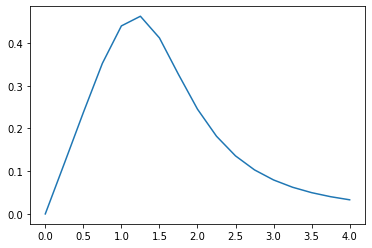

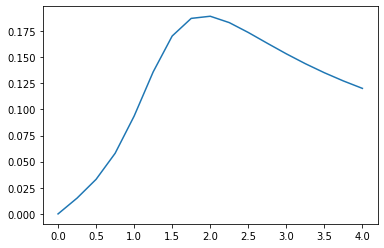

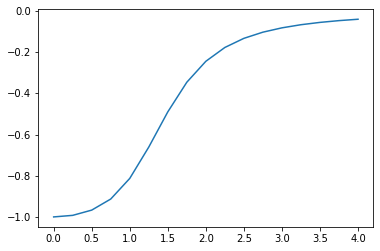

In [23]:
plt.figure()
plt.plot(g_list, sigma_x_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_y_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_z_expect)
plt.show()

In [24]:
time.time()

1580680694.889631

In [25]:
L_list[1] @ rho_list[1].reshape(4 ** num_latt)

array([ 2.37957495e-17+1.22581029e-16j, -7.16082298e-16-2.42502568e-16j,
        2.57393615e-16+7.97982328e-17j, -2.68278204e-16+6.47268697e-17j,
       -3.12837419e-16+3.88894002e-19j,  1.09308840e-15+5.12637045e-17j,
       -1.02769660e-16+1.42230384e-16j, -9.88216399e-17+8.92806608e-17j,
       -8.47264008e-17-2.70942546e-17j,  7.63557850e-18-2.14188374e-16j,
       -1.06951674e-15-1.29376659e-16j,  2.20929910e-16+2.94767466e-17j,
        1.45901425e-17+1.45405911e-17j,  1.02169114e-16+3.70322805e-18j,
       -9.36479626e-17+8.29753475e-18j, -1.62955587e-16-5.64191706e-17j,
        1.90892925e-16+6.37014304e-17j, -1.49338685e-16+2.66613706e-16j,
        1.22953609e-16-1.62736804e-16j,  1.18149238e-16+1.63604414e-16j,
        1.37398908e-16+1.47376776e-16j, -3.99757199e-17+1.06741398e-16j,
        6.25415247e-17+7.00580951e-17j,  2.11656593e-16-1.07796801e-16j,
       -1.20565399e-16+7.03106562e-17j,  1.63409596e-16+3.79250532e-17j,
        4.35434227e-17-1.02615500e-16j,  1.45012041

In [26]:
for g in range(7):
    print(np.linalg.norm(curly_L(rho_list[g], 2, g_list[g])))

7.533813069624854e-15
1.1772529531110136e-14
2.3431573212818783e-14
2.9243191954173255e-14
3.534968999996861e-14
3.704398797618256e-14
4.130281596330975e-14


In [27]:
rho_list

[array([[ 8.93617891e-33-4.47737081e-33j,  2.94654242e-17-1.76737450e-17j,
         -2.11190594e-17+2.56186829e-17j, -6.41829052e-17-1.00023885e-16j,
          2.20709846e-17-4.21029956e-17j, -4.70308017e-17-2.87887591e-16j,
         -2.38064294e-18+1.30353116e-17j,  4.63989118e-17-2.76132911e-17j,
          7.02493414e-17+1.08098345e-16j,  2.17836433e-17-2.06678553e-17j,
          9.68052827e-17+1.42560925e-16j, -4.56119198e-17+2.00125959e-16j,
         -8.63930079e-19+2.44466643e-18j,  3.66642341e-17+1.97079198e-17j,
          2.50500795e-17-4.18357306e-18j, -2.82384167e-16+2.63173351e-16j],
        [-9.41924062e-17+1.14362842e-16j, -3.11821076e-17+2.92508089e-17j,
         -1.49653991e-16+2.94631066e-16j,  5.35220343e-18-4.74834178e-18j,
         -2.77245700e-16+2.22244643e-16j, -3.61814626e-17+1.73010000e-17j,
         -3.34823810e-17-1.66333374e-17j,  2.29430367e-16-2.23236667e-16j,
         -1.44746648e-16+5.43546433e-17j,  9.91990327e-17-2.59033383e-17j,
         -3.11471311e-17

In [28]:
list(map(np.linalg.norm, rho_list))

[1.0,
 0.9998517478131874,
 0.9972245069186747,
 0.9824517459490302,
 0.9329976856056682,
 0.8282130311876317,
 0.6876535446424238,
 0.5586213377285211,
 0.46517515042148205,
 0.40409473778429544,
 0.36477702840653936,
 0.3387821752430909,
 0.3208880276530401,
 0.3080639975860656,
 0.29854310673762086,
 0.29126232061585233,
 0.2855563993815441]